In [53]:
import tensorflow as tf
import csv
import os
import pandas as pd
import numpy as np
import shutil
import random
import PIL
import pydot
import sys
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
import glob
import piexif
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFile
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau 
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import *
from itertools import tee 
from sklearn import metrics
from sklearn.utils.class_weight import compute_sample_weight
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score,precision_score,recall_score
import seaborn as sns

In [54]:
labelsCsv = pd.read_csv("C:/Users/manta/Desktop/new.csv")

# When generating datasets from dataframe,using ImageDataGenerator, we noticed that train and valid sets
# had a class less than the test set. So comparing the labels we realised that one single tittle had the genre
# 'Game-Show' which we have to remove so each set has the same classes
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Game-Show")]
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Short")]
#labelsCsv.to_csv("labels.csv", sep=",", index=False)

nfiles = 0

# We remove exif metadata from pictures and resize them to max size of 128x128, while maintaining the aspect ratio
# of the original photo

#for filename in glob.iglob('E:/IMDB_/*.jpg', recursive=True):
    #nfiles = nfiles + 1
    #print("About to process file %d, which is %s." % (nfiles,filename))
    #piexif.remove(filename)

size=(224, 224)

# for filename in glob.iglob('E:/IMDB_/*.jpg', recursive=True):
#     im = Image.open(filename)
#     im.thumbnail(size, Image.ANTIALIAS)
#     x = filename.split("\\", 1)
#     im.save("C:/IMDB_mr/"+x[1], "JPEG")



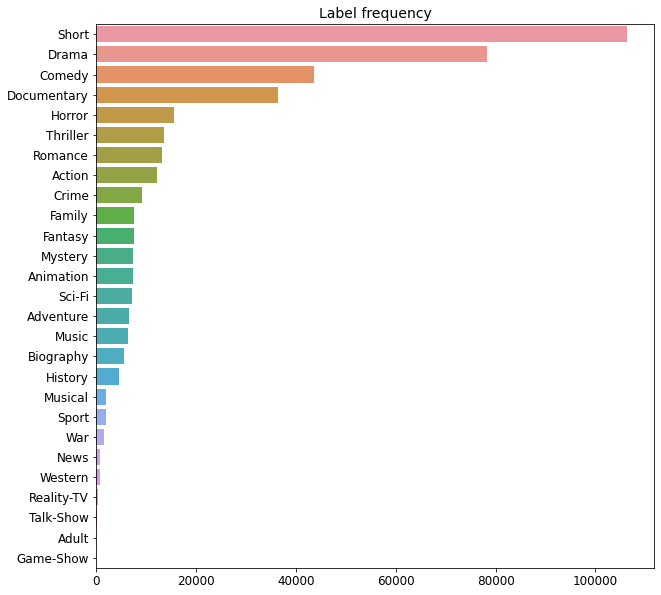

In [55]:
# Get label frequencies in descending order
label_freq = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [56]:
print(label_freq)

Short          106387
Drama           78246
Comedy          43675
Documentary     36538
Horror          15659
Thriller        13613
Romance         13234
Action          12244
Crime            9257
Family           7663
Fantasy          7646
Mystery          7431
Animation        7401
Sci-Fi           7310
Adventure        6581
Music            6331
Biography        5673
History          4589
Musical          2010
Sport            1989
War              1530
News              767
Western           723
Reality-TV        430
Talk-Show         212
Adult              53
Game-Show          22
Name: genres, dtype: int64


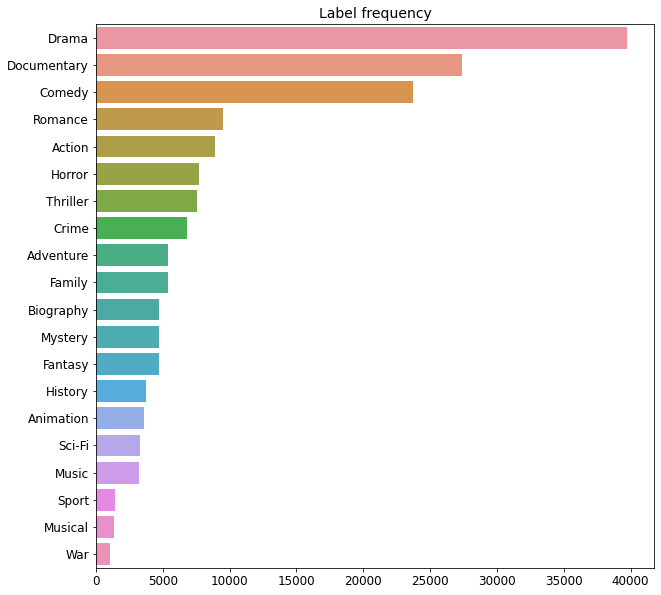

In [57]:
#we keep only the genres with more than 1000 instances 
under1000 = list(label_freq[label_freq<1000].index)
labelsCsv = labelsCsv[~labelsCsv.genres.str.contains('Short')]
for x in under1000:
    labelsCsv = labelsCsv[~labelsCsv.genres.str.contains(x)] 

label_freq_new = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)
# Bar plot after we dropped the classes
plt.figure(figsize=(10,10))
sns.barplot(y=label_freq_new.index.values, x=label_freq_new, order=label_freq_new.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [58]:
print(label_freq_new)

Drama          39754
Documentary    27367
Comedy         23742
Romance         9518
Action          8900
Horror          7690
Thriller        7530
Crime           6792
Adventure       5375
Family          5367
Biography       4753
Mystery         4701
Fantasy         4698
History         3724
Animation       3617
Sci-Fi          3277
Music           3225
Sport           1446
Musical         1346
War             1031
Name: genres, dtype: int64


In [59]:
all_genres = [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]
one_hot = MultiLabelBinarizer()
y_s =one_hot.fit_transform(np.array(all_genres))
y_s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
len(y_s[0])

20

In [61]:
# creating and formating the dataset that we are going to use
d = {'filename' : [tconst + ".jpg" for tconst in labelsCsv.tconst],
    'labels' : [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]}

img_metadata_df = pd.DataFrame(d)

# splitting to train and test
train, test = train_test_split(img_metadata_df, test_size=0.20, random_state=9, shuffle=True)


In [62]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [63]:
THRESHOLD = 0.4
def precision(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))

    precision = tp / (tp + fp)
    return precision


def recall(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))

    recall = tp / (tp + fn)
    return recall

def fbeta(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    #balanced on recall
    beta = 2

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [64]:
def create_dataset_splits(train,test,directory):

    img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

    img_iter_train = img_gen.flow_from_dataframe(
        dataframe=train,
        shuffle=True,
        seed = 42,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        target_size=(224, 224),
        batch_size=100,
        subset='training'
    ) 

    img_iter_val = img_gen.flow_from_dataframe(
        dataframe=train,
        shuffle=True,
        seed=42,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        target_size=(224, 224),
        batch_size=200,
        subset='validation'
    ) 

    test_gen=ImageDataGenerator(rescale=1./255.)

    img_iter_test=test_gen.flow_from_dataframe(
        dataframe=test,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        batch_size=1,
        seed=42,
        shuffle=False,
        target_size=(224, 224)
    )
    
    return img_iter_train,img_iter_val,img_iter_test

def create_weights(generator):
    counter = Counter(x for xs in generator.classes for x in set(xs))                        
    max_val = float(max(counter.values()))       
    class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
    
    return class_weights



In [65]:
def create_model(input_shape,output_dim):
    
    model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_initializer='he_uniform', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25), 
    
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),
        
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(0.25),     
    
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),    
    Dense(output_dim, activation='sigmoid')
    ])
    
    return model

In [66]:
def train_model(model,train_dataset,valid_dataset,test_dataset,class_weights,learning_rate,epochs):
    
    step_train=train_dataset.n//train_dataset.batch_size
    step_valid=valid_dataset.n//valid_dataset.batch_size
    step_test=test_dataset.n//test_dataset.batch_size
    
    
    model.compile(optimizer=Adam(lr = learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy',precision,recall,f1])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_recall', factor=0.1, patience=3, 
                                    verbose=2, mode='max', min_lr=learning_rate/100000)
    
    es = EarlyStopping(monitor = 'val_recall',
                           mode = 'max',
                           verbose = 2,
                           patience = 20,
                           min_delta = 0.0001,
                           restore_best_weights = True)
    
    history = model.fit_generator(
        generator=train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=step_train,
        validation_steps=step_valid,
        class_weight=class_weights,
        callbacks=[reduce_lr,es]
        )
    
    return history

In [67]:
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)

def plot_multilabel_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(15, 60))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

C:\Users\manta\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 64034 validated image filenames belonging to 20 classes.


C:\Users\manta\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 16008 validated image filenames belonging to 20 classes.
Found 20012 validated image filenames belonging to 20 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 32)      128  

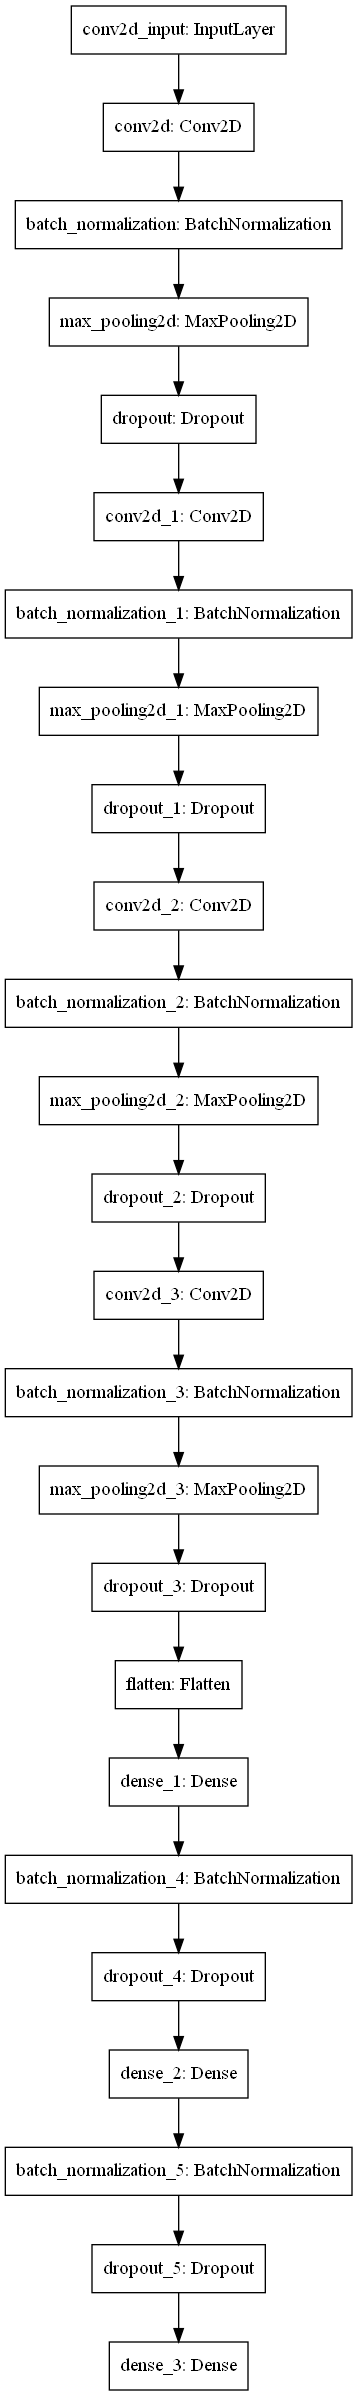

In [68]:
img_iter_train,img_iter_val,img_iter_test = create_dataset_splits(train,test,"C:/IMDB_mr/")
model = create_model((224,224,3),20)
model.summary()
plot_model(model)

In [69]:
class_weights=create_weights(img_iter_train)
history = train_model(model,img_iter_train,img_iter_val,img_iter_test,class_weights, 0.001,80)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
640/640 [==============================] - 99s 155ms/step - loss: 1.3070 - accuracy: 0.1839 - precision: 0.2378 - recall: 0.1712 - f1: 0.0769 - val_loss: 0.2695 - val_accuracy: 0.2366 - val_precision: 0.3931 - val_recall: 0.0104 - val_f1: 5.0161e-04
Epoch 2/80
640/640 [==============================] - 76s 119ms/step - loss: 0.9941 - accuracy: 0.2470 - precision: 0.3303 - recall: 0.0433 - f1: 0.0251 - val_loss: 0.2589 - val_accuracy: 0.2372 - val_precision: 0.3606 - val_recall: 0.0072 - val_f1: 4.9617e-04
Epoch 3/80
640/640 [==============================] - 76s 118ms/step - loss: 0.9708 - accuracy: 0.2644 - precision: 0.3738 - recall: 0.0356 - f1: 0.0167 - val_loss: 0.2534 - val_accuracy: 0.2684 - val_precision: 0.5443 - val_recall: 0.0031 - val_f1: 0.0000e+00
Epoch 4/80
640/640 [==============================] - 76s 118ms/step - loss: 0.9594 - accuracy: 0.2753 - precision: 0.4148 - recall: 0.0355 -

Epoch 30/80
640/640 [==============================] - 77s 120ms/step - loss: 0.7231 - accuracy: 0.3357 - precision: 0.4895 - recall: 0.2672 - f1: 0.2446 - val_loss: 0.2525 - val_accuracy: 0.3045 - val_precision: 0.4110 - val_recall: 0.2209 - val_f1: 0.1744
Epoch 31/80
640/640 [==============================] - 76s 119ms/step - loss: 0.7231 - accuracy: 0.3338 - precision: 0.4890 - recall: 0.2670 - f1: 0.2438 - val_loss: 0.2527 - val_accuracy: 0.3038 - val_precision: 0.4103 - val_recall: 0.2215 - val_f1: 0.1753
Epoch 32/80
640/640 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.3340 - precision: 0.4903 - recall: 0.2672 - f1: 0.2442
Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
640/640 [==============================] - 77s 120ms/step - loss: 0.7245 - accuracy: 0.3340 - precision: 0.4903 - recall: 0.2672 - f1: 0.2442 - val_loss: 0.2528 - val_accuracy: 0.3038 - val_precision: 0.4107 - val_recall: 0.2213 - val_f1: 0.1750
Epoch 33/8

In [70]:
def plotLearningCurves(history):
    fig, ax = plt.subplots(1,2, figsize = (14,6))
    ax[0].plot(history.epoch, history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.epoch, history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    ax[0].legend(loc='best', shadow=True)
    ax[0].set_title('loss vs epoch')

    ax[1].plot(history.epoch, history.history['f1'], color='b', label="Training f1")
    ax[1].plot(history.epoch, history.history['val_f1'], color='r',label="Validation f1")
    ax[1].legend(loc='best', shadow=True)
    ax[1].set_title('f1 vs epoch')

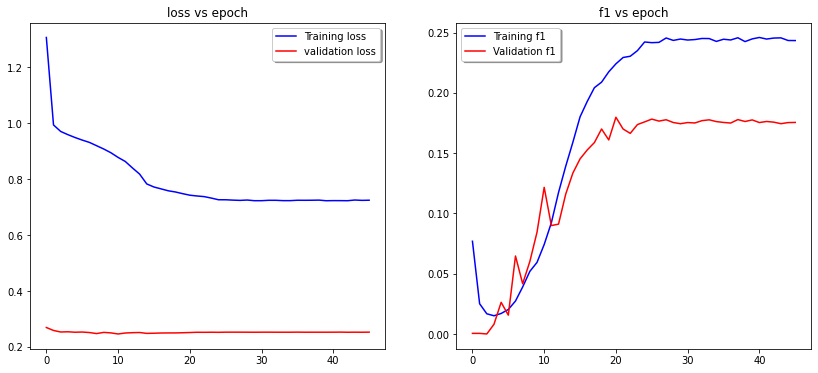

In [71]:
plotLearningCurves(history)

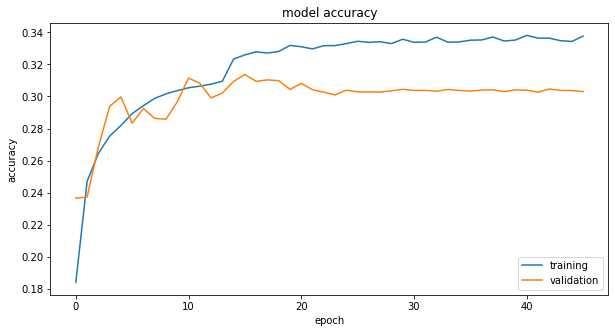

In [72]:
fig= plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [73]:
img_iter_test.reset()
pred=model.predict_generator(img_iter_test,
steps=img_iter_test.n,
verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
20012/20012 [==============================] - 30s 1ms/step


In [74]:
img_iter_test.reset()
model.evaluate_generator(generator = img_iter_test, 
                         steps=img_iter_test.n,
                         verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
20012/20012 [==============================] - 37s 2ms/step - loss: 0.2534 - accuracy: 0.2988 - precision: 0.6008 - recall: 0.2604 - f1: 0.1448


[0.253439724445343,
 0.29882070422172546,
 0.6007696986198425,
 0.2603696286678314,
 0.1448453962802887]

In [75]:
model.save('C:/IMDB_mr/Model/')
np.savetxt("preds.csv", pred, delimiter=",")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:/IMDB_mr/Model/assets


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


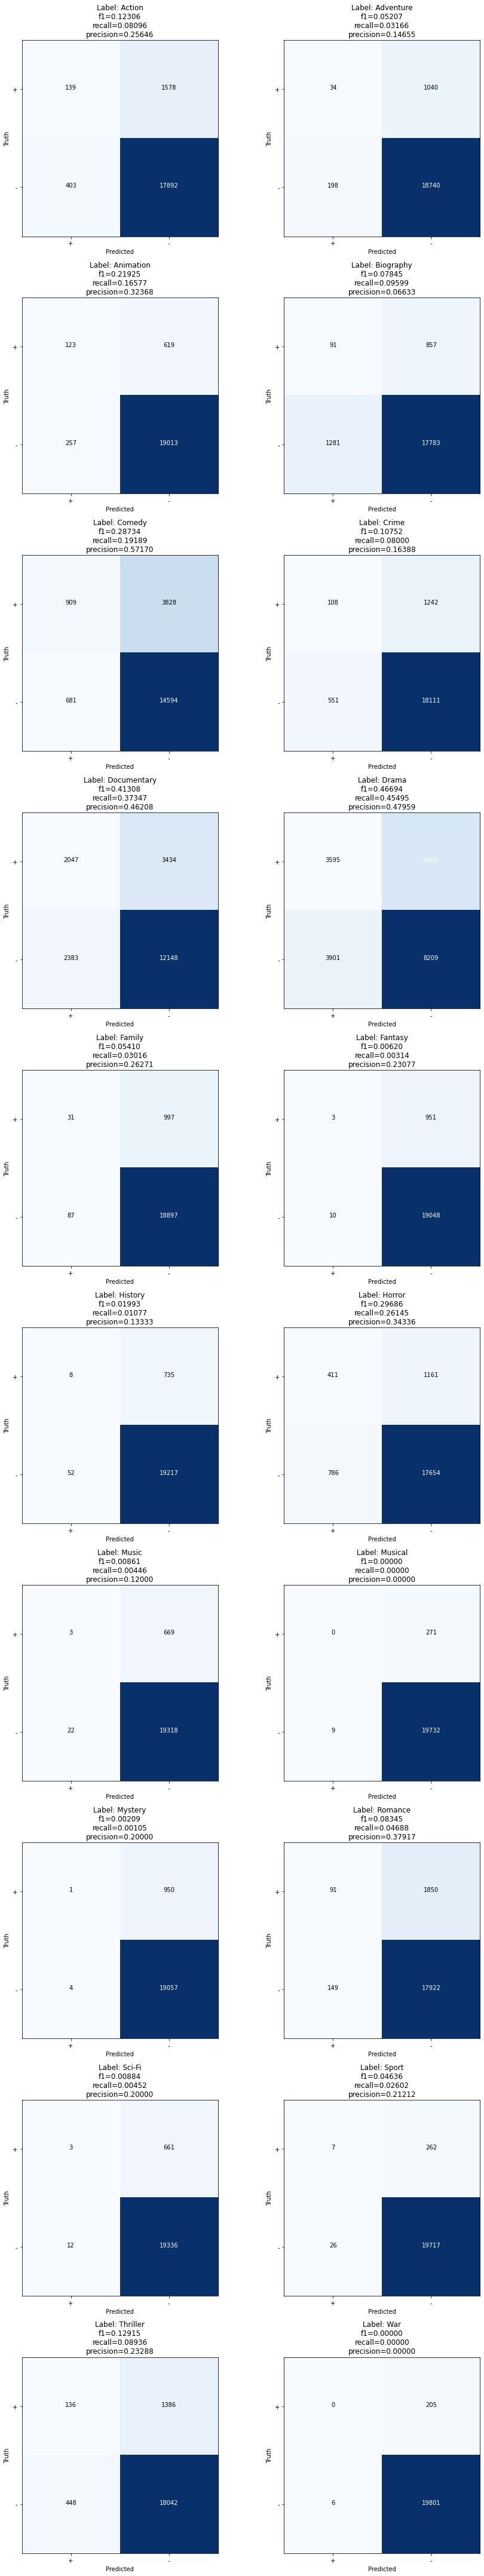

In [77]:
img_iter_test.reset()
label_id_to_class = {v: k for k, v in img_iter_train.class_indices.items()}

nr_batches = img_iter_test.n

threshold = 0.4

img_iter_test_0, img_iter_test_1 = itertools.tee(img_iter_test, 2)
y_true = np.vstack(next(img_iter_test_0)[1] for _ in range(nr_batches)).astype('int')
y_pred = (pred > threshold).astype('int')
plot_multilabel_confusion_matrix(y_true, y_pred, label_id_to_class, save_plot=False)

In [78]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'f1', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1', 'lr'])


# TEXT ANALYSIS

In [21]:
len(labelsCsv.desc)

100056

In [22]:
len(y_s)

100056

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D,GlobalAveragePooling1D, Dropout, Activation
from tensorflow.keras.layers import Embedding
from nltk.stem.snowball import SnowballStemmer 
import re

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
textdata = labelsCsv[['desc','genres']]
textdata= textdata.dropna()
textdata = textdata[textdata['desc'].notnull()]
txtrain, txtest = train_test_split(textdata, test_size=0.20, random_state=9, shuffle=True)

In [25]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"directed", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\=", " = ", text)
    

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text


In [26]:
txtrain['desc'] = txtrain['desc'].map(lambda x: clean_text(x))

c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
### Create sequence
vocabulary_size = 120000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(txtrain['desc'] )   #sto test
sequences = tokenizer.texts_to_sequences(txtrain['desc'] )  #sto test
#vocabulary_size = len(tokenizer.word_index) + 1
maxlen = max([len(x) for x in sequences])
xtrain = pad_sequences(sequences, maxlen)  #kai sto test

print(xtrain.shape)

(79684, 76)


In [28]:
tokenizer.fit_on_texts(txtest['desc'] ) 
sequences_test = tokenizer.texts_to_sequences(txtest['desc'] )
xtest = pad_sequences(sequences_test, maxlen) 
xtest

array([[    0,     0,     0, ...,    38,    18,   491],
       [    0,     0,     0, ...,    18, 11020,   497],
       [    0,     0,     0, ...,    15,     5, 67171],
       ...,
       [63268,     3,  7719, ...,   700,   858, 13522],
       [    0,     0,     0, ...,     5, 14187,  4434],
       [    0,     0,     7, ...,    37,  1331,   261]])

In [29]:
xtrain

array([[    0,     0,     0, ..., 52998, 16419, 78720],
       [    0,     0,     0, ..., 40849,  5493,  1188],
       [    0,     0,     0, ..., 33561,  1294, 33561],
       ...,
       [    0,     0,     0, ...,    10,   166,     7],
       [    0,     0,     0, ...,  2543,   639,   167],
       [    0,     0,     0, ...,   176, 18126, 17021]])

In [30]:
all_genres_tx = [[genre for genre in cel.split(',')] for cel in txtrain.genres] #sto test
ytrain = one_hot.fit_transform(np.array(all_genres_tx))   #sto test
ytrain.shape

(79684, 20)

In [31]:
all_genres_tx_test = [[genre for genre in cel.split(',')] for cel in txtest.genres]
ytest = one_hot.fit_transform(np.array(all_genres_tx_test))  
ytest.shape

(19922, 20)

Extract word embeddings from the Glove


In [32]:
embeddings_index = dict()
f = open('C:/Users/manta/Desktop/glove.6B/glove.6B.200d.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



Create a weight matrix

In [33]:
embedding_matrix = np.zeros((vocabulary_size, 200))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [34]:
len(ytrain[0])

20

In [35]:
vocabulary_size

120000

In [36]:
len(embedding_matrix)


120000

In [37]:
#we change the threshold for precision and recall to 0.5
THRESHOLD=0.5

Develop a model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 76, 200)           24000000  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 76, 200)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 74, 64)            38464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 37, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dense (Dense)                (None, 20)                5140      
Total params: 24,241,236
Trainable params: 241,236
Non-trainable params: 24,000,000
______________________________________

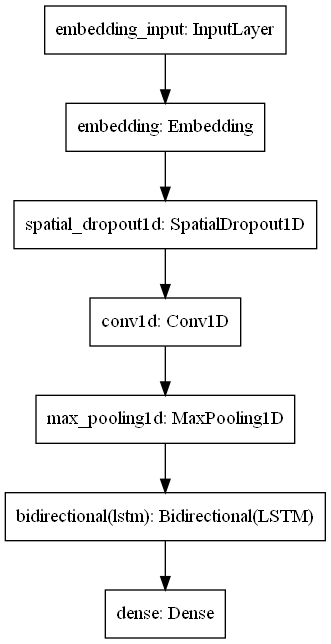

In [38]:
modeltxt = Sequential()
modeltxt.add(Embedding(vocabulary_size, 200, input_length=76, weights=[embedding_matrix], trainable=False))
modeltxt.add(SpatialDropout1D(0.2))
modeltxt.add(Conv1D(64, kernel_size=3, padding = "valid", activation='relu'))
modeltxt.add(MaxPooling1D()),
modeltxt.add(Bidirectional(LSTM(128)))
modeltxt.add(Dense(20, activation='sigmoid'))
modeltxt.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy',recall,precision,f1])
print(modeltxt.summary())
plot_model(modeltxt)

In [39]:
es = EarlyStopping(monitor = 'val_recall',
                           mode = 'max',
                           verbose = 2,
                           patience = 20,
                           min_delta = 0.0001,
                           restore_best_weights = True)

txthistory=modeltxt.fit(xtrain, ytrain, validation_split=0.3, epochs = 100, callbacks=[es])

Epoch 1/100
1744/1744 [==============================] - 17s 10ms/step - loss: 0.2467 - accuracy: 0.2931 - recall: 0.1878 - precision: 0.5038 - f1: 0.1300 - val_loss: 0.2378 - val_accuracy: 0.3467 - val_recall: 0.2601 - val_precision: 0.5165 - val_f1: 0.2470
Epoch 2/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.2314 - accuracy: 0.3536 - recall: 0.2598 - precision: 0.5561 - f1: 0.2677 - val_loss: 0.2271 - val_accuracy: 0.3612 - val_recall: 0.2636 - val_precision: 0.5709 - val_f1: 0.2936
Epoch 3/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.2240 - accuracy: 0.3724 - recall: 0.2861 - precision: 0.5791 - f1: 0.3022 - val_loss: 0.2307 - val_accuracy: 0.3641 - val_recall: 0.2764 - val_precision: 0.5426 - val_f1: 0.2987
Epoch 4/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.2194 - accuracy: 0.3851 - recall: 0.3088 - precision: 0.5818 - f1: 0.3237 - val_loss: 0.2223 - val_accuracy: 0.3718 - val_recall: 0.3179 - val_pr

Epoch 33/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.1872 - accuracy: 0.4720 - recall: 0.4362 - precision: 0.6316 - f1: 0.4644 - val_loss: 0.2246 - val_accuracy: 0.4032 - val_recall: 0.3518 - val_precision: 0.5278 - val_f1: 0.3705
Epoch 34/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.1869 - accuracy: 0.4734 - recall: 0.4380 - precision: 0.6344 - f1: 0.4662 - val_loss: 0.2240 - val_accuracy: 0.4010 - val_recall: 0.3739 - val_precision: 0.5348 - val_f1: 0.4001
Epoch 35/100
1744/1744 [==============================] - 16s 9ms/step - loss: 0.1861 - accuracy: 0.4736 - recall: 0.4407 - precision: 0.6339 - f1: 0.4691 - val_loss: 0.2239 - val_accuracy: 0.4016 - val_recall: 0.3635 - val_precision: 0.5313 - val_f1: 0.3865
Epoch 36/100
1744/1744 [==============================] - 15s 9ms/step - loss: 0.1861 - accuracy: 0.4745 - recall: 0.4413 - precision: 0.6356 - f1: 0.4696 - val_loss: 0.2272 - val_accuracy: 0.3992 - val_recall: 0.3625 - val

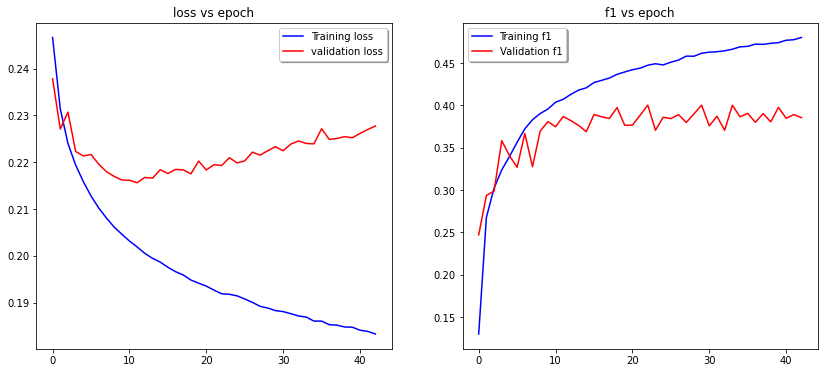

In [42]:
plotLearningCurves(txthistory)

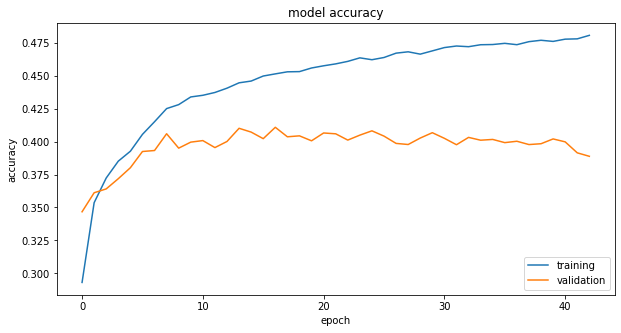

In [45]:
fig= plt.figure(figsize=(10,5))
plt.plot(txthistory.history['accuracy'])
plt.plot(txthistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

In [46]:
modeltxt.evaluate(xtest,ytest,verbose=1)

623/623 [==============================] - 3s 4ms/step - loss: 0.3073 - accuracy: 0.2519 - recall: 0.2572 - precision: 0.3492 - f1: 0.2562


[0.30729153752326965,
 0.2519325315952301,
 0.25724056363105774,
 0.34916460514068604,
 0.2562132179737091]

In [47]:
predtxt=modeltxt.predict(xtest,verbose=1)

623/623 [==============================] - 2s 3ms/step


In [48]:
y_pred = tf.argmax(predtxt, axis=-1)
y_true = tf.argmax(ytest, axis=-1)

cm = tf.math.confusion_matrix(tf.reshape(y_true, [-1]),
                             tf.reshape(y_pred, [-1]))

In [49]:
cm


<tf.Tensor: shape=(20, 20), dtype=int32, numpy=
array([[   0,    0,    9,    0,   60,    4,  684,  979,    9,    1,    0,
           2,    3,    0,    1,    6,    0,    0,    1,    0],
       [   0,    1,    6,    0,   23,    1,  288,  379,    1,    0,    0,
           7,    4,    0,    1,    4,    0,    0,    1,    0],
       [   1,    0,    5,    0,   14,    1,  211,  227,    0,    0,    0,
           2,    1,    0,    0,    3,    0,    0,    0,    0],
       [   1,    3,    3,    0,   30,    0,  312,  521,    0,    1,    0,
           1,    2,    0,    0,    2,    0,    0,    0,    0],
       [   2,   10,   18,    0,  196,    2, 1489, 2165,    9,    2,    0,
          10,   11,    0,    0,   30,    0,    0,    0,    0],
       [   0,    1,    6,    0,   38,    0,  285,  441,    2,    1,    0,
           0,    0,    0,    0,    5,    0,    0,    0,    0],
       [   2,    9,   55,    0,  204,    2, 2124, 2177,   23,    1,    0,
           2,   17,    0,    0,   30,    1,    0,    0, 

In [50]:
def plot_confusion_matrix_txt(cm, class_names):
     
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names.values(), rotation=45)
    plt.yticks(tick_marks, class_names.values())
    
    # Normalize the confusion matrix.
    cm = np.around(cm.numpy() / cm.numpy().sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

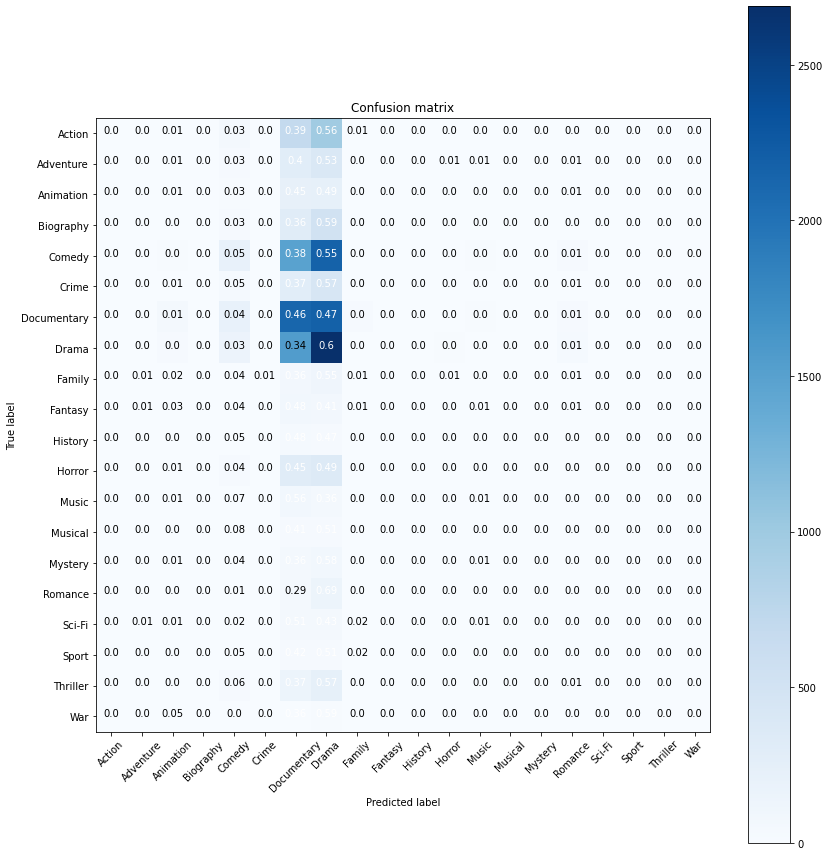

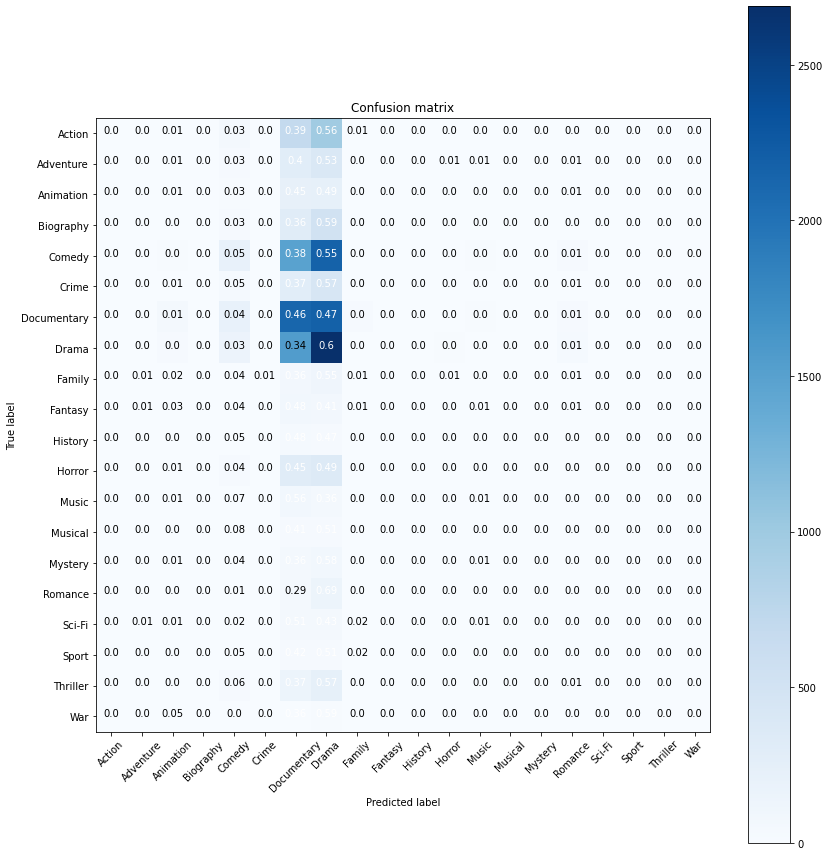

In [79]:
plot_confusion_matrix_txt(cm, label_id_to_class)

In [80]:
modeltxt.save('C:/IMDB_mr/Modeltxt/')

INFO:tensorflow:Assets written to: C:/IMDB_mr/Modeltxt/assets


Multi Modal Model (using keras functional API)

In [ ]:
def normalize_pixels(image):
    #pixels = asarray(image)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    return pixels

In [115]:
def custom_generator(image_dir, dataframe, batch_size):
    i = 0
    image_file_list = os.listdir(image_dir)
    while True:
        batch_x = {'images': list(), 'other_feats': list()}  # use a dict for multiple inputs
        batch_y = list()
        for b in range(batch_size):
            if i == len(image_file_list):
                i = 0
                random.shuffle(image_file_list)
            sample = image_file_list[i]
            image_file_path = sample[0]
            #csv_file_path = os.path.join(csv_dir,
            #                            os.path.basename(image_file_path).replace('.png', '.csv'))
            i += 1
            image = normalize_pixels(cv2.imread(image_file_path))
            other_feat = preprocess_feats(dataframe)
            batch_x['images'].append(image)
            batch_x['other_feats'].append(other_feat)
            batch_y.append(dataframe.loc[image_name, :]['genre'])

        batch_x['images'] = np.array(batch_x['images'])  # convert each list to array
        batch_x['other_feats'] = np.array(batch_x['other_feats'])
        batch_y = np.eye(num_classes)[batch['labels']]
        yield batch_x, batch_y

In [108]:
com_data = labelsCsv[['tconst','desc','genres']]
com_data= com_data.dropna()
com_data = com_data[com_data['desc'].notnull()]
com_data

,tconst,desc,genres
1,tt0035423,"Directed by James Mangold. With Meg Ryan, Hug...","Comedy,Fantasy,Romance"
3,tt0088751,"Directed by Wayne Berwick, Ted Newsom. With K...","Comedy,Horror,Sci-Fi"
4,tt0096056,Directed by Menahem Golan. With Crispin Glove...,Drama
5,tt0102362,Directed by Andrzej Czarnecki. With Mikhail E...,"Drama,Romance"
6,tt0108549,"Directed by Steve Ashlee, Valerie Silver. Wit...","Comedy,Mystery"
...,...,...,...
207870,tt9833368,With Barry Humphries. MAGICAL LAND OF OZ offer...,Documentary
207880,tt9833498,"Directed by ArhyBes, Boris Kravchenko. With B...","Animation,Comedy,Music"
207887,tt9833886,Directed by Daniel Vega Vidal. With Guillermo...,Comedy
207889,tt9834038,Directed by Beau Han Bridge. With Beau Han Br...,Drama


In [109]:
com_data.desc[1]

'Directed by James Mangold.  With Meg Ryan, Hugh Jackman, Liev Schreiber, Breckin Meyer. An English Duke from 1876 is inadvertedly dragged to modern day New York where he falls for a plucky advertising executive.'

In [110]:
# remove descriptions where only director and actors are listed
f = lambda x: x["desc"].split(".", 2)[2:]
com_data["desc"] = com_data.apply(f, axis=1)

com_data

,tconst,desc,genres
1,tt0035423,[ An English Duke from 1876 is inadvertedly dr...,"Comedy,Fantasy,Romance"
3,tt0088751,"[G. Wilson, John Goodwin. A brain-dead sheriff...","Comedy,Horror,Sci-Fi"
4,tt0096056,[ A modern day adaptation of Dostoyevsky's cla...,Drama
5,tt0102362,[],"Drama,Romance"
6,tt0108549,[],"Comedy,Mystery"
...,...,...,...
207870,tt9833368,"[ It's a land of diverse beauty, that delights...",Documentary
207880,tt9833498,[ Batman saves Aquaman from perils far greater...,"Animation,Comedy,Music"
207887,tt9833886,[],Comedy
207889,tt9834038,"[ An adaptation of Dostoevsky's ""Notes From Th...",Drama


In [111]:
#remove rows with empty description

com_data=com_data[(com_data.desc.astype(str).str.len()>4)]

In [114]:
com_data.reset_index(drop=True)

,tconst,desc,genres
0,tt0035423,[ An English Duke from 1876 is inadvertedly dr...,"Comedy,Fantasy,Romance"
1,tt0088751,"[G. Wilson, John Goodwin. A brain-dead sheriff...","Comedy,Horror,Sci-Fi"
2,tt0096056,[ A modern day adaptation of Dostoyevsky's cla...,Drama
3,tt0110476,[ Interwoven are a satire of the 1930's under ...,"Drama,Fantasy"
4,tt0113026,[ A mysterious fair that comes to a small comm...,"Musical,Romance"
...,...,...,...
78151,tt9833362,[ A documentary revisiting the career of a fei...,Documentary
78152,tt9833368,"[ It's a land of diverse beauty, that delights...",Documentary
78153,tt9833498,[ Batman saves Aquaman from perils far greater...,"Animation,Comedy,Music"
78154,tt9834038,"[ An adaptation of Dostoevsky's ""Notes From Th...",Drama


Define multi-branched model

In [120]:
input_shape_image = tf.keras.Input(shape=input_shape_img)
input_shape_text = tf.keras.Input(shape=input_shape_txt)


x = Conv2D(filters=16, kernel_size=(3,3), activation="relu", kernel_initializer='he_uniform') (input_shape_image)
x = BatchNormalization() (x)
x = MaxPooling2D(pool_size=(2, 2)) (x)
x = Dropout(0.25) (x)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu') (x)
x = BatchNormalization() (x)
x = MaxPooling2D(pool_size=(2, 2)) (x)
x = Dropout(0.25) (x)
x = Conv2D(filters=128, kernel_size=(3,3), activation='relu') (x)
x = BatchNormalization() (x)
x = MaxPooling2D(pool_size=(2, 2)) (x)
x = Dropout(0.25) (x)
x = Flatten() (x)
x = Dense(128, activation='relu') (x)
x = BatchNormalization() (x)
x = Dropout(0.4) (x)
x = Dense(256, activation='relu') (x)
x = BatchNormalization() (x)
x = Dropout(0.3)  (x)   
x = Model(inputs=input_shape_image, outputs=x)


y = Embedding(vocabulary_size, 200, input_length=76, weights=[embedding_matrix], trainable=False) (input_shape_text)
y = SpatialDropout1D(0.2)
y = Bidirectional(LSTM(128, return_sequences=True))
y = Conv1D(64, kernel_size=3, padding = "valid", activation='relu')
y = GlobalAveragePooling1D()
y = Model(inputs=input_shape_text, outputs=y)

combined = concatenate([x.output, y.output])

z = Dense(64, activation="relu")(combined)
z = Dense(20, activation="signmoid")(z)

multi_model = Model(inputs=[x.input, y.input], outputs=z)

NameError: name 'input_shape_img' is not defined

In [ ]:

image = Image.open('sydney_bridge.jpg')
def normalize_pixels(image):
    pixels = asarray(image)
    pixels = pixels.astype('float32')
    pixels /= 255.0
    print(pixels)